# CI Project
* Carlijn Sangers
* Juriaan Wagenaar
* Jesse Kassai
* Rowan Duits



In [1]:
import pandas as pd
import json
from pandas import Series, DataFrame
import numpy as np


def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

In [2]:
# Load data for town 
data_path = './data/denver/'
# vaudreuil-dorion
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

## 1: Content based (categories)

In [3]:
def split_data(data, d = 0.75):
    """Split data in a training and test set.
    
    Arguments:
    data -- any dataFrame.
    d    -- the fraction of data in the training set
    """
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

# Remove all businesses without any category
subset = businesses.copy()
subset = subset[subset['categories'] != np.nan]
subset = subset.replace(to_replace='None', value=np.nan).dropna().reset_index()
bus_in_subset = subset['business_id'].tolist()


# Drop unimportant columns
subset = subset.drop(['address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'hours', 'index'], axis=1)

# Create test and trainging set
reviews_filtered = reviews[reviews['business_id'].isin(bus_in_subset)]
reviews_training, reviews_test = split_data(reviews_filtered, d=0.9)

# Extract categories
def extract(businesses):
    cat_m = businesses.apply(lambda row: pd.Series([row['business_id']] + row['categories'].lower().split(",")), axis=1)
    stack_cat = cat_m.set_index(0).stack()
    df_stack_cat = stack_cat.to_frame()
    df_stack_cat['business_id'] = stack_cat.index.droplevel(1)
    df_stack_cat.columns = ['categories', 'business_id']
    return df_stack_cat.reset_index()[['business_id', 'categories']]


extracted_df = extract(subset)

# Create utility matrix (row = business, column = category, value = binair (1 = yes, 0 = no))
def pivot_cats(df):
    return df.pivot_table(index = 'business_id', columns = 'categories', aggfunc = 'size', fill_value=0)

utility_cat = pivot_cats(extracted_df)
display(utility_cat)

categories,active life,american (new),american (traditional),apartments,auto glass services,auto repair,automotive,bagels,bars,beauty & spas,...,professional services,restaurants,salad,sandwiches,shades & blinds,shopping,specialty food,sports bars,sushi bars,waxing
business_id,,,,,,,,,,,,,,,,,,,,,
-Rr4TuM1tWhagDcLTp_qUQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
-WDEZ9zidT995DBY6psNYg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-eVgCMCS_UrMfe7LrJY20g,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0-ftV2vyTWXlCS9gSjRfEA,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0VTBFP4_BulLj7h6DHHLRA,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x8PpA97u2tuh21GLlYOIrA,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
xYZFc1_UyetsGn5hqvbWSA,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
ySEX_WXPLpKrmXfZOth4Bw,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Create similarity (businesses)
def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)

similarity_cat = create_similarity_matrix_jaccard(utility_cat)


def pivot_stars(df):
    return df.pivot_table(index = 'business_id', columns = 'user_id', values='stars')

utility_stars = pivot_stars(reviews_filtered)


display(utility_stars)

user_id,-85qgL4N-OdDfYa4XV81Ow,-Hc4mLmYngyC6x83mguTlw,-QosOE3O0grwD9y_qp63UA,-RkHttlt6LHGweXojWJC3Q,-TkqYJ_zBoyjiC1DGLMdPw,-UTPjjYGaXQTQkkX8ymmQg,-_0Ro9wPMMELtrAI1WQpsA,-dEj_3-_M4ud5A1_uDmeUg,-ewT3rfmmrfD49k0t5cLLA,-ovK9Xw2K1oyp8DzgzFBfQ,...,zAFSF_hmQZiCOJcV3dZDng,zCbUKA-L-b3_eyNqeffpLw,zOcxdtX-xW5SCnS-4uN3yQ,zY1UPnlcuHqjN86-MiLOPQ,zc_4JuN0nkcgF5IF2BU8nw,zf6CLQ_wzwMJk2CHPwKZbA,zf6lPc4rNVCeZmjX4OkvWw,zmsGTEY6XLhwzEn3amGV5w,zxblyibxHCxNagUg2WYNIA,zyR4ie42CYCFz84NBQjx5w
business_id,,,,,,,,,,,,,,,,,,,,,
-Rr4TuM1tWhagDcLTp_qUQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-WDEZ9zidT995DBY6psNYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-eVgCMCS_UrMfe7LrJY20g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0-ftV2vyTWXlCS9gSjRfEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0VTBFP4_BulLj7h6DHHLRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x8PpA97u2tuh21GLlYOIrA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xYZFc1_UyetsGn5hqvbWSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN
ySEX_WXPLpKrmXfZOth4Bw,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN


In [5]:
def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    similarities = similarities[similarities > 0]
    ratings = ratings.dropna()    
    items = Series(similarities, index=(ratings.index.tolist())).dropna()
    
    
    return items[:k]

def weighted_mean(neighborhood, ratings): 
    t = np.nansum(neighborhood * ratings)
    if t == 0:
        return np.nan
    n = sum(neighborhood.values)
    
    predicted_rating = t/n       
    return predicted_rating

def predict_ratings(similarity, utility, user_item_pairs, k=100):
    ratings_test_c = user_item_pairs.copy()

    
    users = ratings_test_c['user_id'].tolist()
    items = ratings_test_c['business_id'].tolist()
    amount = len(users)
    
    predicted = [weighted_mean(select_neighborhood(similarity[(items[item])], utility[(users[item])], k) , 
                                                                utility[users[item]]) for item in range(amount)]

    ratings_test_c['predicted rating'] = predicted
    return ratings_test_c

predicted_content_based_cat = predict_ratings(similarity_cat, utility_stars, reviews_test[['user_id', 'business_id', 'stars']])
# predicted_content_based_cat = predicted_content_based_cat[predicted_content_based_cat['predicted rating'] > 0]
display(predicted_content_based_cat)

,user_id,business_id,stars,predicted rating
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0,1.000000
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0,1.000000
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0,5.000000
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0,2.257143
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0,5.000000
...,...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0,1.000000
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0,3.614525
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0,2.000000
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0,5.000000


## 2: Content based (attributes) 

In [6]:
# Remove all businesses without any category
subset = load_jsons(data_path, business_file)
subset = subset[subset['attributes'] != np.nan]
subset = subset.replace(to_replace='None', value=np.nan).dropna().reset_index()

# display(subset['attributes'][10])

testbusiness = subset['attributes'][0]

businesses = subset['business_id'].tolist()
attributes = subset['attributes'].tolist()

columns = []

for index in range(len(businesses)):
    business = businesses[index]
    attribute = attributes[index]
    
    
    for item in attribute:
        # if item consists more items (dicts)
        if type(item) == dict:
            for part in item:
                # if attribute value is True
                if attribute[part] == "True" or attribute[part] == "False":
                    columns.append(part)
         
        
        # if item is attribute
        else:
            # if attribute value is True
            if attribute[item] == "True" or attribute[item] == "False":
                columns.append(item)
               
columns = list(set(columns))        
utility_att = DataFrame(index=businesses, columns=columns)   
display(utility_att)

,BikeParking,ByAppointmentOnly,HappyHour,OutdoorSeating,BusinessAcceptsBitcoin,GoodForDancing,CoatCheck,BusinessAcceptsCreditCards,RestaurantsTakeOut,Caters,RestaurantsDelivery,DriveThru,WheelchairAccessible,GoodForKids,RestaurantsReservations,HasTV,RestaurantsGoodForGroups,RestaurantsTableService
-Rr4TuM1tWhagDcLTp_qUQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KILiLLcArAs1sLzcjAPo8A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_KA1DfzngdobPFdoeEO51g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b_kVn5GxxZcHB8ulBrBpXQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9MeCpRNXkixOsDWi0wxt1Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lq0GU5roR4uBuHW4RC44iQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7ZYwDS2DD1jPlY3ekk7DZQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3KYNGSNgl_mPGf6xgORblQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEamwep3RrC_cK45ht8x6Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
for index in range(len(businesses)):
    business = businesses[index]
    attribute = attributes[index]
    
    
    for item in attribute:
        # if item consists more items (dicts)
        if type(item) == dict:
            for part in item:
                # if attribute value is True
                if attribute[item] == "True":
                    df_utility.loc[businesses[index], part] = 1
                if attribute[item] == "False":
                    df_utility.loc[businesses[index], part] = 0
         
        
        # if item is attribute
        else:
            # if attribute value is True
            if attribute[item] == "True":
                utility_att.loc[businesses[index], item] = 1
            if attribute[item] == "False":
                utility_att.loc[businesses[index], item] = 0

utility_att = utility_att.fillna(0)
display(utility_att)


,BikeParking,ByAppointmentOnly,HappyHour,OutdoorSeating,BusinessAcceptsBitcoin,GoodForDancing,CoatCheck,BusinessAcceptsCreditCards,RestaurantsTakeOut,Caters,RestaurantsDelivery,DriveThru,WheelchairAccessible,GoodForKids,RestaurantsReservations,HasTV,RestaurantsGoodForGroups,RestaurantsTableService
-Rr4TuM1tWhagDcLTp_qUQ,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
KILiLLcArAs1sLzcjAPo8A,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
_KA1DfzngdobPFdoeEO51g,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
b_kVn5GxxZcHB8ulBrBpXQ,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0
9MeCpRNXkixOsDWi0wxt1Q,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lq0GU5roR4uBuHW4RC44iQ,1,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,1,0
7ZYwDS2DD1jPlY3ekk7DZQ,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0
3KYNGSNgl_mPGf6xgORblQ,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
GEamwep3RrC_cK45ht8x6Q,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [8]:
similarity_att = create_similarity_matrix_jaccard(utility_att)
display(similarity_att)

,-Rr4TuM1tWhagDcLTp_qUQ,KILiLLcArAs1sLzcjAPo8A,_KA1DfzngdobPFdoeEO51g,b_kVn5GxxZcHB8ulBrBpXQ,9MeCpRNXkixOsDWi0wxt1Q,jmGYmRHT76WZFLllFGQn_g,xYZFc1_UyetsGn5hqvbWSA,za-FG6MKrfEVCWp-xEQeig,epJBPuPpe4vKFqqasB1ANQ,OzetqRL_CK1hQDV62lQvOA,...,2EQu9A8JdexwVDoo5-fTbQ,I7Llfbo9t-19yJi6CSQI7g,VmHxpBIkq6sbsv2uL7VY3A,23qU9y6SsacIbektcA8ecw,hl0kpITwBJfSBYXEgeRP1w,Lq0GU5roR4uBuHW4RC44iQ,7ZYwDS2DD1jPlY3ekk7DZQ,3KYNGSNgl_mPGf6xgORblQ,GEamwep3RrC_cK45ht8x6Q,ZAyuSdDGdeD-HtucNgMK_w
-Rr4TuM1tWhagDcLTp_qUQ,1.000000,0.166667,0.500000,0.625000,0.333333,0.285714,0.600000,0.142857,0.625000,0.571429,...,0.142857,0.333333,0.166667,0.625000,0.571429,0.666667,0.363636,0.166667,0.166667,0.142857
KILiLLcArAs1sLzcjAPo8A,0.166667,1.000000,0.333333,0.142857,0.500000,0.333333,0.100000,0.500000,0.142857,0.200000,...,0.500000,0.500000,1.000000,0.142857,0.200000,0.111111,0.111111,1.000000,1.000000,0.500000
_KA1DfzngdobPFdoeEO51g,0.500000,0.333333,1.000000,0.428571,0.250000,0.200000,0.300000,0.250000,0.250000,0.333333,...,0.250000,0.250000,0.333333,0.250000,0.600000,0.333333,0.200000,0.333333,0.333333,0.250000
b_kVn5GxxZcHB8ulBrBpXQ,0.625000,0.142857,0.428571,1.000000,0.125000,0.111111,0.700000,0.125000,0.555556,0.714286,...,0.125000,0.125000,0.142857,0.400000,0.333333,0.777778,0.600000,0.142857,0.142857,0.125000
9MeCpRNXkixOsDWi0wxt1Q,0.333333,0.500000,0.250000,0.125000,1.000000,0.666667,0.200000,0.333333,0.285714,0.166667,...,0.333333,1.000000,0.500000,0.285714,0.400000,0.222222,0.100000,0.500000,0.500000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lq0GU5roR4uBuHW4RC44iQ,0.666667,0.111111,0.333333,0.777778,0.222222,0.200000,0.900000,0.100000,0.600000,0.555556,...,0.100000,0.222222,0.111111,0.600000,0.400000,1.000000,0.636364,0.111111,0.111111,0.100000
7ZYwDS2DD1jPlY3ekk7DZQ,0.363636,0.111111,0.200000,0.600000,0.100000,0.200000,0.583333,0.100000,0.454545,0.555556,...,0.100000,0.100000,0.111111,0.454545,0.272727,0.636364,1.000000,0.111111,0.111111,0.100000
3KYNGSNgl_mPGf6xgORblQ,0.166667,1.000000,0.333333,0.142857,0.500000,0.333333,0.100000,0.500000,0.142857,0.200000,...,0.500000,0.500000,1.000000,0.142857,0.200000,0.111111,0.111111,1.000000,1.000000,0.500000
GEamwep3RrC_cK45ht8x6Q,0.166667,1.000000,0.333333,0.142857,0.500000,0.333333,0.100000,0.500000,0.142857,0.200000,...,0.500000,0.500000,1.000000,0.142857,0.200000,0.111111,0.111111,1.000000,1.000000,0.500000


In [9]:
predicted_content_based_att = predict_ratings(similarity_att, utility_stars, reviews_test[['user_id', 'business_id', 'stars']])

display(predicted_content_based_att)

,user_id,business_id,stars,predicted rating
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0,1.000000
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0,1.000000
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0,5.000000
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0,3.652226
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0,4.821656
...,...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0,1.000000
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0,3.600446
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0,2.000000
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0,5.000000


In [10]:
def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    diff = predicted_ratings['stars'] - predicted_ratings['predicted rating']
    return (diff**2).mean()

print('mse content based (categories): ', mse(predicted_content_based_cat))
print('mse content based (attributes): ', mse(predicted_content_based_att))

mse content based (categories):  0.16747616382149508
mse content based (attributes):  0.45089913827671924


In [11]:
display(reviews_test[['user_id', 'business_id', 'stars']])

,user_id,business_id,stars
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0
...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0


In [12]:
import random
df_for_random = reviews_test[['user_id', 'business_id', 'stars']]
column_random = [random.uniform(0.0, 5.0) for x in range(len(df_for_random.index.tolist()))]
df_for_random['predicted rating'] = column_random

display(df_for_random)

print('mse random: ', mse(df_for_random))

C:\Users\rduit\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,user_id,business_id,stars,predicted rating
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0,4.886576
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0,1.142071
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0,3.409822
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0,3.632567
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0,0.037223
...,...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0,1.923493
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0,0.701070
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0,0.052263
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0,2.768838


mse random:  6.075348751964897


## 3: Content based (SpaCy business profile similarities)

In [13]:
import spacy
nlp = spacy.load('en_core_web_md')

In [14]:
reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)

display(subset.head())

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,2,-Rr4TuM1tWhagDcLTp_qUQ,Dunkin' Donuts,647 N Hwy 16,Denver,NC,28037,35.460411,-80.992598,2.0,15,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Sandwiches, Restaurants, Food, Coffee & Tea, D...","{'Monday': '5:0-23:0', 'Tuesday': '5:0-23:0', ..."
1,5,KILiLLcArAs1sLzcjAPo8A,Sure-Safe Moving and Storage,1675 Hwy 16 N,Denver,NC,28037,35.488317,-80.996614,3.0,6,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Movers, Home Services, Truck Rental, Self Stor...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
2,7,_KA1DfzngdobPFdoeEO51g,Cabbellas Coffee Shop,1250 Hwy 16 N,Denver,NC,28037,35.481920,-80.994644,5.0,21,1,"{'RestaurantsPriceRange2': '1', 'BikeParking':...","Food, Ice Cream & Frozen Yogurt, Coffee & Tea","{'Monday': '6:0-17:0', 'Tuesday': '6:0-17:0', ..."
3,8,b_kVn5GxxZcHB8ulBrBpXQ,Yamato,751 N Hwy 16,Denver,NC,28037,35.463160,-80.993622,1.5,13,0,"{'RestaurantsAttire': ''casual'', 'HasTV': 'Tr...","Sushi Bars, Japanese, Steakhouses, Restaurants","{'Tuesday': '16:0-22:0', 'Wednesday': '16:0-22..."
4,10,9MeCpRNXkixOsDWi0wxt1Q,Triangle Food Mart & Cafe,1298 N Highway 16,Denver,NC,28037,35.478205,-80.993055,4.5,7,1,"{'BusinessParking': '{'garage': False, 'street...","Food, Butcher, Grocery","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."


In [15]:
series_cat = Series(subset['categories'].tolist(), index=subset['business_id'].tolist())


df_nlp_similarity = pd.DataFrame(index=series_cat.index, columns=series_cat.index)

for column in df_nlp_similarity.columns:
    similarity_column = []
    
    doc1 = nlp(series_cat[column])
    
    for row in df_nlp_similarity.index:
        doc2 = nlp(series_cat[row])
        similarity_column.append(doc1.similarity(doc2))
        
    df_nlp_similarity[column] = similarity_column

        


display(df_nlp_similarity)

,-Rr4TuM1tWhagDcLTp_qUQ,KILiLLcArAs1sLzcjAPo8A,_KA1DfzngdobPFdoeEO51g,b_kVn5GxxZcHB8ulBrBpXQ,9MeCpRNXkixOsDWi0wxt1Q,jmGYmRHT76WZFLllFGQn_g,xYZFc1_UyetsGn5hqvbWSA,za-FG6MKrfEVCWp-xEQeig,epJBPuPpe4vKFqqasB1ANQ,OzetqRL_CK1hQDV62lQvOA,...,2EQu9A8JdexwVDoo5-fTbQ,I7Llfbo9t-19yJi6CSQI7g,VmHxpBIkq6sbsv2uL7VY3A,23qU9y6SsacIbektcA8ecw,hl0kpITwBJfSBYXEgeRP1w,Lq0GU5roR4uBuHW4RC44iQ,7ZYwDS2DD1jPlY3ekk7DZQ,3KYNGSNgl_mPGf6xgORblQ,GEamwep3RrC_cK45ht8x6Q,ZAyuSdDGdeD-HtucNgMK_w
-Rr4TuM1tWhagDcLTp_qUQ,1.000000,0.703429,0.889597,0.868173,0.854450,0.724324,0.895917,0.609158,0.760526,0.928541,...,0.640362,0.854895,0.552867,0.939680,0.927384,0.879182,0.935442,0.673561,0.603377,0.589873
KILiLLcArAs1sLzcjAPo8A,0.703429,1.000000,0.604065,0.645354,0.709197,0.879744,0.835529,0.758711,0.624461,0.706990,...,0.880478,0.683204,0.798611,0.712832,0.671143,0.751897,0.680749,0.802952,0.842396,0.712093
_KA1DfzngdobPFdoeEO51g,0.889597,0.604065,1.000000,0.722715,0.757939,0.645667,0.773823,0.553124,0.600890,0.787681,...,0.600643,0.783158,0.487140,0.817348,0.976979,0.726620,0.819492,0.599486,0.512769,0.532319
b_kVn5GxxZcHB8ulBrBpXQ,0.868173,0.645354,0.722715,1.000000,0.804697,0.665089,0.871453,0.549132,0.897387,0.894249,...,0.592236,0.770865,0.536077,0.883408,0.807468,0.905093,0.900596,0.624989,0.552949,0.540366
9MeCpRNXkixOsDWi0wxt1Q,0.854450,0.709197,0.757939,0.804697,1.000000,0.729370,0.832946,0.575339,0.709056,0.893104,...,0.617647,0.950541,0.576660,0.838194,0.814469,0.799893,0.855868,0.677944,0.571235,0.624530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lq0GU5roR4uBuHW4RC44iQ,0.879182,0.751897,0.726620,0.905093,0.799893,0.736152,0.956841,0.629436,0.823792,0.881938,...,0.675701,0.775974,0.609679,0.883348,0.812907,1.000000,0.876437,0.732940,0.652136,0.620309
7ZYwDS2DD1jPlY3ekk7DZQ,0.935442,0.680749,0.819492,0.900596,0.855868,0.696900,0.887292,0.573622,0.790373,0.941744,...,0.613555,0.838722,0.545360,0.951676,0.888022,0.876437,1.000000,0.644134,0.564829,0.582709
3KYNGSNgl_mPGf6xgORblQ,0.673561,0.802952,0.599486,0.624989,0.677944,0.757467,0.792091,0.658286,0.583784,0.654616,...,0.732248,0.646839,0.686898,0.665840,0.660052,0.732940,0.644134,1.000000,0.692869,0.682267
GEamwep3RrC_cK45ht8x6Q,0.603377,0.842396,0.512769,0.552949,0.571235,0.798098,0.738994,0.707876,0.572734,0.587984,...,0.745873,0.545867,0.589344,0.618353,0.562440,0.652136,0.564829,0.692869,1.000000,0.638502


In [16]:
predicted_content_based_cat_sim = predict_ratings(df_nlp_similarity, utility_stars, reviews_test[['user_id', 'business_id', 'stars']])

In [17]:
display(predicted_content_based_cat_sim)


,user_id,business_id,stars,predicted rating
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0,1.000000
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0,1.000000
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0,5.000000
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0,4.023698
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0,4.767615
...,...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0,1.000000
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0,3.644294
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0,2.000000
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0,5.000000


## Collaborative (user-based)

In [18]:
def pivot_ratings(ratings):
    "Create utility matrix"
    return ratings.pivot(index='business_id', columns='user_id', values='stars')

def filter(reviews):
    "Filter dataframe where user gave more than 1 review to same business"
    userslist = reviews['user_id'].tolist()
    bus = reviews['business_id'].tolist()
    s = reviews['stars'].tolist()

    user_id = []
    business_id = []
    stars = []

    check = []
    for x in range(len(userslist)):
        string = '-'.join([userslist[x], bus[x]])
    
        # Ignore rating if user has already rated the business
        if string in check:
            pass
        else:
            check.append(string)
            user_id.append(userslist[x])
            business_id.append(bus[x])
            stars.append(s[x])


    df = pd.DataFrame()
    df['user_id'] = user_id
    df['business_id'] = business_id
    df['stars'] = stars
    return df

In [19]:
df = filter(reviews)
utility = (pivot_ratings(df)).T
display(utility)

business_id,-3PHn7uGXNaOytVl1JnovQ,-Rr4TuM1tWhagDcLTp_qUQ,-WDEZ9zidT995DBY6psNYg,-eVgCMCS_UrMfe7LrJY20g,0-ftV2vyTWXlCS9gSjRfEA,06JXcrsxH-dDeyMVz51Pqg,0VTBFP4_BulLj7h6DHHLRA,1Qq41uLzLrrralYzzphSdg,23qU9y6SsacIbektcA8ecw,29pDo7smnzdFr2XrcMKxGw,...,uO1F-NyzGuzOqtj9Oa6fOw,wpK9fDZCquKc-y1JeQ4HCA,x04le5eTqdzeDajOGUdNoQ,x8PpA97u2tuh21GLlYOIrA,xYZFc1_UyetsGn5hqvbWSA,xraXmUqsT49CxcFSfLPzeQ,xykr9ywm-VaIbnyXeReYEg,ySEX_WXPLpKrmXfZOth4Bw,yrj0LDjxc3z_t3EOvpQrJg,za-FG6MKrfEVCWp-xEQeig
user_id,,,,,,,,,,,,,,,,,,,,,
-5hqMtwueU8cEeWjbc3wCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-85qgL4N-OdDfYa4XV81Ow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN
-Hc4mLmYngyC6x83mguTlw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-QosOE3O0grwD9y_qp63UA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-RkHttlt6LHGweXojWJC3Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zf6lPc4rNVCeZmjX4OkvWw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zid7ZHfYVoKq1pzEgjVBRw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zmsGTEY6XLhwzEn3amGV5w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


In [20]:
def cosine_similarity(matrix, id1, id2):
    # only take the features that have values for both id1 and id2
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    if id1 == id2:
        return 1
    
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    ratings_id1 = matrix.loc[id1][selected_features].tolist()
    ratings_id2 = matrix.loc[id2][selected_features].tolist()
    
    rating_amount = len(ratings_id1)
    
#     formula cos = n/d
    numerator = sum([ratings_id1[x]*ratings_id2[x] for x in range(rating_amount)])
    denominator = (sum([(ratings_id1[x])**2 for x in range(rating_amount)]) * sum([(ratings_id2[x])**2 
                                                                               for x in range(rating_amount)]))**0.5
    if denominator == 0:
        return np.nan
    cos = numerator/denominator
    return cos
    
def create_similarity_matrix_cosine(matrix):
    similarity_matrix = pd.DataFrame(0, index=sorted(matrix.index), columns=sorted(matrix.index), dtype=float)

    userrows = sorted(matrix.index.tolist())  
    usercolumns = userrows
    
    columns = [[cosine_similarity(matrix, user1, user2) for user2 in userrows] for user1 in usercolumns]
    
    no = 0
    for column in similarity_matrix:
        similarity_matrix[column] = columns[no]
        no = no + 1
    
    return similarity_matrix

In [21]:
sim = create_similarity_matrix_cosine(utility)
display(sim)

,-5hqMtwueU8cEeWjbc3wCA,-85qgL4N-OdDfYa4XV81Ow,-Hc4mLmYngyC6x83mguTlw,-QosOE3O0grwD9y_qp63UA,-RkHttlt6LHGweXojWJC3Q,-TkqYJ_zBoyjiC1DGLMdPw,-UTPjjYGaXQTQkkX8ymmQg,-_0Ro9wPMMELtrAI1WQpsA,-dEj_3-_M4ud5A1_uDmeUg,-ewT3rfmmrfD49k0t5cLLA,...,zCbUKA-L-b3_eyNqeffpLw,zOcxdtX-xW5SCnS-4uN3yQ,zY1UPnlcuHqjN86-MiLOPQ,zc_4JuN0nkcgF5IF2BU8nw,zf6CLQ_wzwMJk2CHPwKZbA,zf6lPc4rNVCeZmjX4OkvWw,zid7ZHfYVoKq1pzEgjVBRw,zmsGTEY6XLhwzEn3amGV5w,zxblyibxHCxNagUg2WYNIA,zyR4ie42CYCFz84NBQjx5w
-5hqMtwueU8cEeWjbc3wCA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
-85qgL4N-OdDfYa4XV81Ow,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.941742,1.0,NaN,NaN,NaN,1.0,NaN,NaN
-Hc4mLmYngyC6x83mguTlw,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-QosOE3O0grwD9y_qp63UA,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-RkHttlt6LHGweXojWJC3Q,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zf6lPc4rNVCeZmjX4OkvWw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
zid7ZHfYVoKq1pzEgjVBRw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,NaN
zmsGTEY6XLhwzEn3amGV5w,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.990830,NaN,NaN,NaN,NaN,1.0,NaN,NaN
zxblyibxHCxNagUg2WYNIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [22]:
def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    similarities = similarities[similarities > 0]
    ratings = ratings.dropna()    
    items = Series(similarities, index=(ratings.index.tolist())).dropna()
    
    
    return items[:k]

def weighted_mean(neighborhood, ratings): 
    t = np.nansum(neighborhood * ratings)
    if t == 0:
        return np.nan
    n = sum(neighborhood.values)
    
    predicted_rating = t/n       
    return predicted_rating

def predict_ratings_user_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    
    users = ratings_test_c['user_id'].tolist()
    bus = ratings_test_c['business_id'].tolist()
    amount = len(users)
    
    predicted = [weighted_mean(select_neighborhood(similarity[(users[item])], utility[(bus[item])], 100) , 
                                                                utility[bus[item]]) for item in range(amount)]

    ratings_test_c['predicted rating'] = predicted
    return ratings_test_c

user_based = predict_ratings_user_based(sim, utility, reviews_test[['user_id', 'business_id', 'stars']])
display(user_based)

,user_id,business_id,stars,predicted rating
12,IlD0kin-Xw47pvqMtGCqNw,KILiLLcArAs1sLzcjAPo8A,1.0,3.000000
52,mShIjlaDAldeRlx6HS1isg,-Rr4TuM1tWhagDcLTp_qUQ,1.0,1.866667
53,9AC8CXO70htNxHbXKnnKOA,_KA1DfzngdobPFdoeEO51g,5.0,4.857143
79,qYy-3QNvEDW5mBSQwOzBgw,b_kVn5GxxZcHB8ulBrBpXQ,1.0,1.307836
85,5AahN3B7_AMvHudxsO205g,_KA1DfzngdobPFdoeEO51g,5.0,4.857028
...,...,...,...,...
1626,PkRjylfotPNyYh9Fgzd3dQ,ZAyuSdDGdeD-HtucNgMK_w,1.0,3.666667
1664,dbbWHu2Hvr3rcE8Z--kRRg,Lq0GU5roR4uBuHW4RC44iQ,4.0,3.710075
1665,jeDF--Oy5xdL6jBhqfgFRg,Lq0GU5roR4uBuHW4RC44iQ,2.0,3.695652
1669,vXWPR1LxA_NuFawbhc6xKA,Lq0GU5roR4uBuHW4RC44iQ,5.0,3.695652


In [23]:
print('mse random: ', mse(df_for_random))
print("----------------------------------------------------------------------")
print('mse content based (categories): ', mse(predicted_content_based_cat))
print('mse content based (attributes): ', mse(predicted_content_based_att))
print('mse content based (similarity): ', mse(predicted_content_based_cat_sim))
print("----------------------------------------------------------------------")
print('mse collaborative (user-based): ', mse(user_based))

mse random:  6.075348751964897
----------------------------------------------------------------------
mse content based (categories):  0.16747616382149508
mse content based (attributes):  0.45089913827671924
mse content based (similarity):  0.7091408706968951
----------------------------------------------------------------------
mse collaborative (user-based):  2.0504316985790227


In [24]:
k_values = [1, 2, 3, 4, 5, 10, 100]

df_mse = DataFrame(columns=k_values, index=['CB Categories', 'CB Attributes', 'CB SpaCy Similarities', 'Collab'])
index = df_mse.index.tolist()
ks = df_mse.columns.tolist()



for k in ks:
    column = []
    for method in index:
        if method == "CB Categories":
            sim = similarity_cat.copy()
        if method == "CB Attributes":
            sim = similarity_att.copy()
        if method == "CB SpaCy Similarities":
            sim = df_nlp_similarity.copy()
        if method == "Collab":
            sim = sim.copy()
            
        column.append(mse(predict_ratings(sim, utility_stars, reviews_test[['user_id', 'business_id', 'stars']], k)))
    df_mse[k] = column
        

display(df_mse)       

,1,2,3,4,5,10,100
CB Categories,1.440574,0.530259,0.303924,0.258192,0.182842,0.167476,0.167476
CB Attributes,1.799180,0.785588,0.523563,0.567902,0.496319,0.452243,0.450899
CB SpaCy Similarities,1.930328,0.980508,0.781603,0.812408,0.738471,0.711847,0.709141
Collab,1.930328,0.980508,0.781603,0.812408,0.738471,0.711847,0.709141


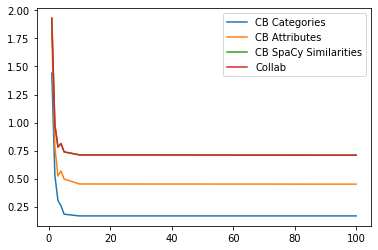

In [25]:
df_mse.T.plot()

### Evaluatie


In [26]:
display(utility_stars)

user_id,-85qgL4N-OdDfYa4XV81Ow,-Hc4mLmYngyC6x83mguTlw,-QosOE3O0grwD9y_qp63UA,-RkHttlt6LHGweXojWJC3Q,-TkqYJ_zBoyjiC1DGLMdPw,-UTPjjYGaXQTQkkX8ymmQg,-_0Ro9wPMMELtrAI1WQpsA,-dEj_3-_M4ud5A1_uDmeUg,-ewT3rfmmrfD49k0t5cLLA,-ovK9Xw2K1oyp8DzgzFBfQ,...,zAFSF_hmQZiCOJcV3dZDng,zCbUKA-L-b3_eyNqeffpLw,zOcxdtX-xW5SCnS-4uN3yQ,zY1UPnlcuHqjN86-MiLOPQ,zc_4JuN0nkcgF5IF2BU8nw,zf6CLQ_wzwMJk2CHPwKZbA,zf6lPc4rNVCeZmjX4OkvWw,zmsGTEY6XLhwzEn3amGV5w,zxblyibxHCxNagUg2WYNIA,zyR4ie42CYCFz84NBQjx5w
business_id,,,,,,,,,,,,,,,,,,,,,
-Rr4TuM1tWhagDcLTp_qUQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-WDEZ9zidT995DBY6psNYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-eVgCMCS_UrMfe7LrJY20g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0-ftV2vyTWXlCS9gSjRfEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0VTBFP4_BulLj7h6DHHLRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x8PpA97u2tuh21GLlYOIrA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xYZFc1_UyetsGn5hqvbWSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN
ySEX_WXPLpKrmXfZOth4Bw,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN


In [69]:
display(sim)

,-Rr4TuM1tWhagDcLTp_qUQ,KILiLLcArAs1sLzcjAPo8A,_KA1DfzngdobPFdoeEO51g,b_kVn5GxxZcHB8ulBrBpXQ,9MeCpRNXkixOsDWi0wxt1Q,jmGYmRHT76WZFLllFGQn_g,xYZFc1_UyetsGn5hqvbWSA,za-FG6MKrfEVCWp-xEQeig,epJBPuPpe4vKFqqasB1ANQ,OzetqRL_CK1hQDV62lQvOA,...,2EQu9A8JdexwVDoo5-fTbQ,I7Llfbo9t-19yJi6CSQI7g,VmHxpBIkq6sbsv2uL7VY3A,23qU9y6SsacIbektcA8ecw,hl0kpITwBJfSBYXEgeRP1w,Lq0GU5roR4uBuHW4RC44iQ,7ZYwDS2DD1jPlY3ekk7DZQ,3KYNGSNgl_mPGf6xgORblQ,GEamwep3RrC_cK45ht8x6Q,ZAyuSdDGdeD-HtucNgMK_w
-Rr4TuM1tWhagDcLTp_qUQ,1.000000,0.703429,0.889597,0.868173,0.854450,0.724324,0.895917,0.609158,0.760526,0.928541,...,0.640362,0.854895,0.552867,0.939680,0.927384,0.879182,0.935442,0.673561,0.603377,0.589873
KILiLLcArAs1sLzcjAPo8A,0.703429,1.000000,0.604065,0.645354,0.709197,0.879744,0.835529,0.758711,0.624461,0.706990,...,0.880478,0.683204,0.798611,0.712832,0.671143,0.751897,0.680749,0.802952,0.842396,0.712093
_KA1DfzngdobPFdoeEO51g,0.889597,0.604065,1.000000,0.722715,0.757939,0.645667,0.773823,0.553124,0.600890,0.787681,...,0.600643,0.783158,0.487140,0.817348,0.976979,0.726620,0.819492,0.599486,0.512769,0.532319
b_kVn5GxxZcHB8ulBrBpXQ,0.868173,0.645354,0.722715,1.000000,0.804697,0.665089,0.871453,0.549132,0.897387,0.894249,...,0.592236,0.770865,0.536077,0.883408,0.807468,0.905093,0.900596,0.624989,0.552949,0.540366
9MeCpRNXkixOsDWi0wxt1Q,0.854450,0.709197,0.757939,0.804697,1.000000,0.729370,0.832946,0.575339,0.709056,0.893104,...,0.617647,0.950541,0.576660,0.838194,0.814469,0.799893,0.855868,0.677944,0.571235,0.624530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lq0GU5roR4uBuHW4RC44iQ,0.879182,0.751897,0.726620,0.905093,0.799893,0.736152,0.956841,0.629436,0.823792,0.881938,...,0.675701,0.775974,0.609679,0.883348,0.812907,1.000000,0.876437,0.732940,0.652136,0.620309
7ZYwDS2DD1jPlY3ekk7DZQ,0.935442,0.680749,0.819492,0.900596,0.855868,0.696900,0.887292,0.573622,0.790373,0.941744,...,0.613555,0.838722,0.545360,0.951676,0.888022,0.876437,1.000000,0.644134,0.564829,0.582709
3KYNGSNgl_mPGf6xgORblQ,0.673561,0.802952,0.599486,0.624989,0.677944,0.757467,0.792091,0.658286,0.583784,0.654616,...,0.732248,0.646839,0.686898,0.665840,0.660052,0.732940,0.644134,1.000000,0.692869,0.682267
GEamwep3RrC_cK45ht8x6Q,0.603377,0.842396,0.512769,0.552949,0.571235,0.798098,0.738994,0.707876,0.572734,0.587984,...,0.745873,0.545867,0.589344,0.618353,0.562440,0.652136,0.564829,0.692869,1.000000,0.638502


In [70]:
## Content based #1
sim = create_similarity_matrix_cosine(utility)
def prediction_item(similarity, utility, u):
    businesses = utility.index.tolist()
    
    index = []
    values = []
    
    for b in businesses:
        n = select_neighborhood(similarity[b], utility[u], 100)
        p = weighted_mean(n, utility[u])
        index.append(b)
        values.append(weighted_mean(n, utility[u]))

    prediction = Series(values, index=index).dropna().sort_values(ascending=False)[:20]
    return prediction
    
def prediction_user(similarity, utility, u):
    businesses = utility.columns.tolist()
    
    index = []
    values = []
    
    for b in businesses:
        n = select_neighborhood(similarity[u], utility[b], 100)
        p = weighted_mean(n, utility[b])
        index.append(b)
        values.append(weighted_mean(n, utility[u]))

    prediction = Series(values, index=index).dropna().sort_values(ascending=False)[:20]
    return prediction


c1 = prediction_item(similarity_cat, utility_stars, "-85qgL4N-OdDfYa4XV81Ow")
c2 = prediction_item(similarity_att, utility_stars, "-85qgL4N-OdDfYa4XV81Ow")
c3 = prediction_item(df_nlp_similarity, utility_stars, "-85qgL4N-OdDfYa4XV81Ow")
# u1 = prediction_user(sim, utility, "-85qgL4N-OdDfYa4XV81Ow")

uu = "-85qgL4N-OdDfYa4XV81Ow"
bb = '-Rr4TuM1tWhagDcLTp_qUQ'

ntest = select_neighborhood(sim[uu], utility[bb], 100)

print(c1)
print("----------------------------------")
print(c2)
print("----------------------------------")
print(c3)
print("----------------------------------")

# def prediction()

GKrorB27irixW6gVSK03iA    4.579545
LstSAbRd5NRZ6HkmlSd30Q    4.548579
5Tt43x1bZsJiG8l-KQjqbQ    4.208062
KfCAV-javso3RlaUrGVoYw    4.195652
foezb6XCQ2_bWLd2M5LICA    4.125000
cpIR38EDGN4q_eREyH_aqg    4.125000
OzetqRL_CK1hQDV62lQvOA    4.074803
29pDo7smnzdFr2XrcMKxGw    4.074803
23qU9y6SsacIbektcA8ecw    4.037037
Sqbx1-q5b8DbqWPWnBkBqQ    4.029126
VGcV3yStTzGaOrW9CsDx-Q    4.000000
2EQu9A8JdexwVDoo5-fTbQ    4.000000
3KYNGSNgl_mPGf6xgORblQ    4.000000
9MeCpRNXkixOsDWi0wxt1Q    4.000000
IxLCzn4R0BRMBfm8zkBzcg    4.000000
KILiLLcArAs1sLzcjAPo8A    4.000000
za-FG6MKrfEVCWp-xEQeig    4.000000
_KA1DfzngdobPFdoeEO51g    4.000000
b31OBrLOlIAGtlu22ik6OQ    4.000000
epJBPuPpe4vKFqqasB1ANQ    4.000000
dtype: float64
----------------------------------
5Tt43x1bZsJiG8l-KQjqbQ    4.434783
-WDEZ9zidT995DBY6psNYg    4.174734
KfCAV-javso3RlaUrGVoYw    4.114108
LstSAbRd5NRZ6HkmlSd30Q    4.106289
VGcV3yStTzGaOrW9CsDx-Q    4.062130
29pDo7smnzdFr2XrcMKxGw    4.053836
GgMPvgqB7JJaKAPClXxpjA    4.032000
kgdS2

In [87]:
# u1 = prediction_user(sim, utility, "-85qgL4N-OdDfYa4XV81Ow")

def prediction_user(similarity, utility, u, businesses):
    
    index = []
    values = []
    
    for b in businesses:
        n = select_neighborhood(sim[u], utility[b], 100)
        p = weighted_mean(n, utility[b])
        index.append(b)
        values.append(p)
    prediction = Series(values, index=index).dropna().sort_values(ascending=False)[:20]
    return prediction

u1 = prediction_user(sim, utility, '-85qgL4N-OdDfYa4XV81Ow', buslist)

In [88]:
display(businesses)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6unlYN_fetLS9zjsmj73Pw,Verizon,7180 Highway 73,Denver,NC,28037,35.448931,-81.002851,1.5,3,1,None,"Internet Service Providers, Home Services, Sho...","{'Monday': '10:0-20:0', 'Tuesday': '10:0-20:0'..."
1,06JXcrsxH-dDeyMVz51Pqg,QC Nails & Spa,1229 N Hwy 16,Denver,NC,28037,35.476168,-80.994222,4.5,6,1,"{'BusinessParking': '{'garage': False, 'street...","Beauty & Spas, Nail Salons",None
2,-Rr4TuM1tWhagDcLTp_qUQ,Dunkin' Donuts,647 N Hwy 16,Denver,NC,28037,35.460411,-80.992598,2.0,15,1,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Sandwiches, Restaurants, Food, Coffee & Tea, D...","{'Monday': '5:0-23:0', 'Tuesday': '5:0-23:0', ..."
3,EJ8RasQ8QfdjTjIB2pLpmQ,Enterprise Rent-A-Car,1633 N Highway 16,Denver,NC,28037,35.487106,-80.995723,4.0,5,1,None,"Hotels & Travel, Car Rental","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,E3wdfyZo3pyUH1LxhANmnQ,China II Denver,116 Hwy 16 S,Denver,NC,28037,35.446547,-80.998802,4.0,40,1,"{'BikeParking': 'False', 'RestaurantsTakeOut':...","Chinese, Restaurants",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,mvgG_9yCb4tnYLt0T1Fg4w,The Silver Grill,1476 N Hwy 16,Denver,NC,28037,35.482124,-80.994592,3.5,32,1,"{'HasTV': 'True', 'NoiseLevel': 'u'loud'', 'Bu...","American (Traditional), Restaurants",None
112,A7pvt3w3YeKJolPhSqEhRw,Lowe's,7144 Highway 73,Denver,NC,28037,35.448627,-81.004141,2.0,13,1,"{'BikeParking': 'False', 'BusinessParking': '{...","Home Services, Fashion, Home & Garden, Hardwar...",None
113,NIv7kj5fQHMaLxRj-gtKlA,Kangaroo Express,7405 W Hwy 73,Denver,NC,28037,35.446322,-80.996388,4.0,3,0,{'BusinessAcceptsCreditCards': 'True'},"Gas Stations, Automotive",None
114,GEamwep3RrC_cK45ht8x6Q,Five Star Painting,"274 N Hwy 16 Business, Ste 400",Denver,NC,28037,35.450418,-80.994314,1.5,8,0,{'BusinessAcceptsCreditCards': 'True'},"Home Services, Painters","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."


In [124]:
def set_categories(predicted):
    bus = predicted.index.tolist()
    ratings = predicted.values.tolist()
    categories = []
  
    for b in bus:
        cats = businesses[businesses['business_id'] == b]['categories']
       
        categories.append(cats.values.tolist()[0])
        
    df = DataFrame(index=bus)
    df['predicted'] = ratings
    df['categories'] = categories

    return df

In [125]:
c_1 = set_categories(c1)
c_2 = set_categories(c2)
c_3 = set_categories(c3)
u_1 = set_categories(u1)

In [126]:
display(c_1)

,predicted,categories
GKrorB27irixW6gVSK03iA,4.579545,"American (New), Restaurants"
LstSAbRd5NRZ6HkmlSd30Q,4.548579,"Bars, Nightlife, Sports Bars, Beer Bar, Mexica..."
5Tt43x1bZsJiG8l-KQjqbQ,4.208062,"Fast Food, Tex-Mex, Mexican, Restaurants"
KfCAV-javso3RlaUrGVoYw,4.195652,"Barbeque, Restaurants"
foezb6XCQ2_bWLd2M5LICA,4.125000,"Restaurants, Mexican"
cpIR38EDGN4q_eREyH_aqg,4.125000,"Pizza, Italian, Restaurants"
OzetqRL_CK1hQDV62lQvOA,4.074803,"Fast Food, Delis, Sandwiches, Restaurants"
29pDo7smnzdFr2XrcMKxGw,4.074803,"Salad, Restaurants, Fast Food, Chicken Wings"
23qU9y6SsacIbektcA8ecw,4.037037,"Cafes, Breakfast & Brunch, Salad, Restaurants,..."
Sqbx1-q5b8DbqWPWnBkBqQ,4.029126,"American (Traditional), Diners, Burgers, Resta..."


In [128]:
display(c_2)

,predicted,categories
5Tt43x1bZsJiG8l-KQjqbQ,4.434783,"Fast Food, Tex-Mex, Mexican, Restaurants"
-WDEZ9zidT995DBY6psNYg,4.174734,"Chicken Wings, Food, Restaurants, Chicken Shop..."
KfCAV-javso3RlaUrGVoYw,4.114108,"Barbeque, Restaurants"
LstSAbRd5NRZ6HkmlSd30Q,4.106289,"Bars, Nightlife, Sports Bars, Beer Bar, Mexica..."
VGcV3yStTzGaOrW9CsDx-Q,4.062130,"Restaurants, American (Traditional), Burgers"
29pDo7smnzdFr2XrcMKxGw,4.053836,"Salad, Restaurants, Fast Food, Chicken Wings"
GgMPvgqB7JJaKAPClXxpjA,4.032000,"Professional Services, Boat Repair, Boat Chart..."
kgdS2dCx2aqkmyQYQ23Z9g,4.027778,"Hair Salons, Beauty & Spas"
_KA1DfzngdobPFdoeEO51g,3.967966,"Food, Ice Cream & Frozen Yogurt, Coffee & Tea"
GKrorB27irixW6gVSK03iA,3.949537,"American (New), Restaurants"


In [129]:
display(c_3)

,predicted,categories
GKrorB27irixW6gVSK03iA,3.859870,"American (New), Restaurants"
NhbNk6CxHZbNx8wG7eBf8w,3.853926,"Mexican, Restaurants, American (New), American..."
foezb6XCQ2_bWLd2M5LICA,3.853158,"Restaurants, Mexican"
epJBPuPpe4vKFqqasB1ANQ,3.849133,"Restaurants, Japanese"
LXXI1I9WHLjDatyteZCsYA,3.844499,"Karaoke, American (New), Nightlife, Sports Bar..."
DDLhT-sHkI_hMzqLONgQmw,3.843345,"Car Dealers, Automotive"
0VTBFP4_BulLj7h6DHHLRA,3.842379,"Automotive, Auto Repair"
Z3ejq-KQS9Lx4iuT4r7CMw,3.839630,"Restaurants, Italian, Pizza, American (New)"
UeowoS_TiyLXNIoM4_LQ2Q,3.839411,"Food, American (New), Restaurants"
Lq0GU5roR4uBuHW4RC44iQ,3.836210,"Sports Bars, Nightlife, Bars, Burgers, Restaur..."


In [130]:
display(u_1)

,predicted,categories
za-FG6MKrfEVCWp-xEQeig,5.000000,"Shades & Blinds, Shutters, Home Services"
f_qRjKxHueFR-__dXq_wlA,5.000000,"Body Shops, Automotive, Auto Repair"
0-ftV2vyTWXlCS9gSjRfEA,5.000000,"Auto Repair, Tires, Smog Check Stations, Autom..."
06JXcrsxH-dDeyMVz51Pqg,5.000000,"Beauty & Spas, Nail Salons"
0VTBFP4_BulLj7h6DHHLRA,5.000000,"Automotive, Auto Repair"
2EQu9A8JdexwVDoo5-fTbQ,5.000000,"Car Window Tinting, Windshield Installation & ..."
2s4wpe4sSXSMPWkRI0LaiA,5.000000,"Physical Therapy, Health & Medical"
3KYNGSNgl_mPGf6xgORblQ,5.000000,"Firearm Training, Specialty Schools, Shopping,..."
9MeCpRNXkixOsDWi0wxt1Q,5.000000,"Food, Butcher, Grocery"
Afi4EviGu5PfR-d7_OyqQQ,5.000000,"Automotive, Car Wash"
